In [1]:
from captum.attr import DeepLift,Saliency,NoiseTunnel,IntegratedGradients,visualization as viz
import torch,torchvision,numpy as np,torch.nn as nn,torch.optim as optim,matplotlib.pyplot as plt,torchvision.transforms as transforms,torch.nn.functional as F
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                   (0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        self.relu4=nn.ReLU()
    def forward(self,x):
        x=self.pool1(self.relu1(self.conv1(x)))
        x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=self.relu3(self.fc1(x))
        x=self.relu4(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
for epoch in range(5):
    running_loss=0
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if i%2000==1999:
            print(f'[{epoch+1}-{i+1}] Loss: {running_loss/2000:.3f}')
            running_loss=0
print('Finished training')
torch.save(net.state_dict(),'cifar_torchvision.pt')

[1-2000] Loss: 2.244
[1-4000] Loss: 1.871
[1-6000] Loss: 1.655
[1-8000] Loss: 1.578
[1-10000] Loss: 1.492
[1-12000] Loss: 1.436
[2-2000] Loss: 1.402
[2-4000] Loss: 1.354
[2-6000] Loss: 1.320
[2-8000] Loss: 1.313
[2-10000] Loss: 1.287
[2-12000] Loss: 1.271
[3-2000] Loss: 1.207
[3-4000] Loss: 1.190
[3-6000] Loss: 1.185
[3-8000] Loss: 1.171
[3-10000] Loss: 1.177
[3-12000] Loss: 1.160
[4-2000] Loss: 1.085
[4-4000] Loss: 1.095
[4-6000] Loss: 1.101
[4-8000] Loss: 1.109
[4-10000] Loss: 1.113
[4-12000] Loss: 1.092
[5-2000] Loss: 1.011
[5-4000] Loss: 1.027
[5-6000] Loss: 1.028
[5-8000] Loss: 1.041
[5-10000] Loss: 1.034
[5-12000] Loss: 1.061
Finished training


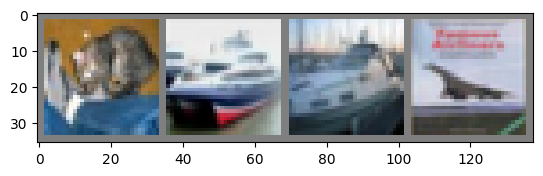

Groundtruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [2]:
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter=iter(testloader)
images,labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join(f'{classes[labels[j]]:>5}' for j in range(4)))
outputs=net(images)
_,predicted=torch.max(outputs,1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:>5}' for j in range(4)))

In [3]:
ind=3
input=images[ind].unsqueeze(0)
input.requires_grad=True
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [4]:
def attribute_image_features(algorithm,input,**kwargs):
    net.zero_grad()
    tensor_attributions=algorithm.attribute(input,target=labels[ind],**kwargs)
    return tensor_attributions
saliency=Saliency(net)
grads=saliency.attribute(input,target=labels[ind].item())
grads=np.transpose(grads.squeeze().cpu().detach().numpy(),(1,2,0))
ig=IntegratedGradients(net)
attr_ig,delta=attribute_image_features(ig,input,baselines=input*0,return_convergence_delta=True)
attr_ig=np.transpose(attr_ig.squeeze().cpu().detach().numpy(),(1,2,0))
print(f'Approximation delta: {abs(delta)}')

Approximation delta: tensor([0.0131])


Original image
Predicted: plane
Probability: 0.924838125705719


/Users/I568200/.pyenv/versions/Environment/lib/python3.14/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


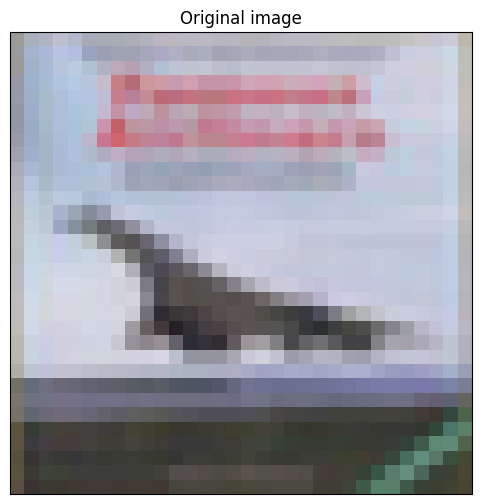

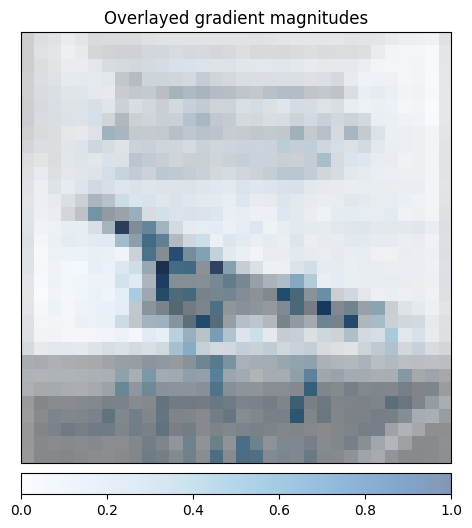

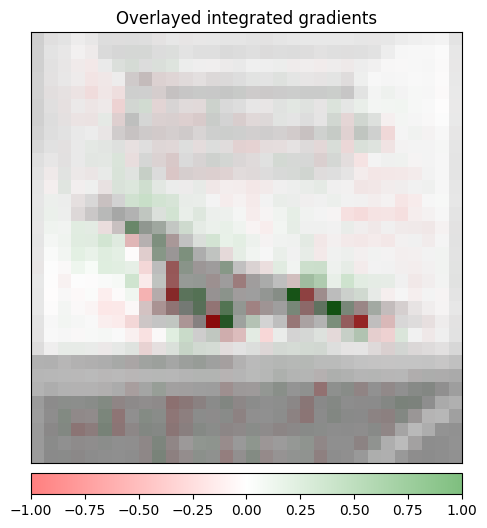

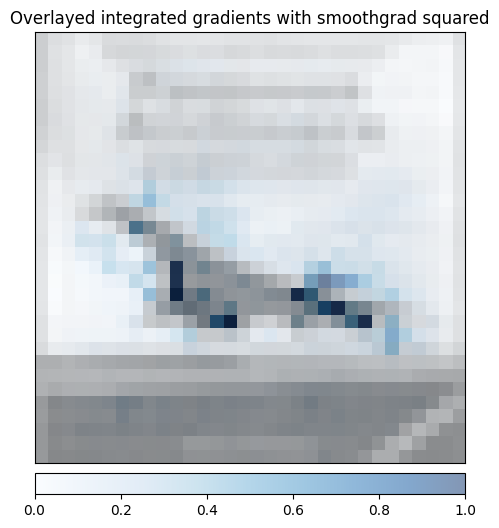

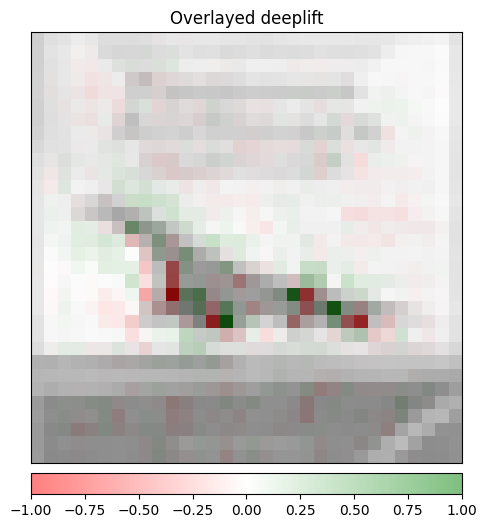

In [5]:
nt=NoiseTunnel(ig)
attr_ig_nt=attribute_image_features(nt,input,baselines=input*0,nt_type='smoothgrad_sq',nt_samples=100,stdevs=0.2)
attr_ig_nt=np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(),(1,2,0))
dl=DeepLift(net)
attr_dl=attribute_image_features(dl,input,baselines=input*0)
attr_dl=np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(),(1,2,0))
print(f'Original image\nPredicted: {classes[predicted[ind]]}\nProbability: {torch.max(F.softmax(outputs,1)).item()}')
original_image=np.transpose((images[ind].cpu().detach().numpy()/2)+0.5,(1,2,0))
_=viz.visualize_image_attr(np.ones_like(original_image),original_image,method='original_image',title='Original image')
_=viz.visualize_image_attr(grads,original_image,method='blended_heat_map',sign='absolute_value',show_colorbar=True,title='Overlayed gradient magnitudes')
_=viz.visualize_image_attr(attr_ig,original_image,method='blended_heat_map',sign='all',show_colorbar=True,title='Overlayed integrated gradients')
_=viz.visualize_image_attr(attr_ig_nt,original_image,method='blended_heat_map',sign='absolute_value',outlier_perc=10,show_colorbar=True,title='Overlayed integrated gradients with smoothgrad squared')
_=viz.visualize_image_attr(attr_dl,original_image,method='blended_heat_map',sign='all',show_colorbar=True,title='Overlayed deeplift')